In [54]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [55]:
# from google.colab import drive

# drive.mount('/content/drive')

In [57]:
## reproducible results
# https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
seed_value= 123
os.environ['PYTHONHASHSEED']=str(seed_value) # Set the `PYTHONHASHSEED` environment
random.seed(seed_value) # built in seed
np.random.seed(seed_value) # numpy seed
tf.random.set_seed(seed_value) # tf seed

In [58]:
## load data set
## https://medium.com/@ashraf.dasa/tensorflow-image-classification-of-colorectal-cancer-histology-92-5-accuracy-8b8b40ac775a
ds, metadata = tfds.load(
    "colorectal_histology",split="train", as_supervised=True,with_info=True
    )   

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/colorectal_histology/2.0.0.incompleteDRF0RG/colorectal_histology-train.tfrecor…

Dataset colorectal_histology downloaded and prepared to ~/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [59]:
SIZE = len(ds)
SIZE

5000

In [23]:
num_classes = metadata.features['label'].num_classes
print(num_classes) ## number of classes

8


In [24]:
class_names=metadata.features['label'].names
print(class_names) ## class names

['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']


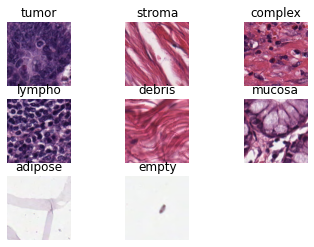

In [60]:
## https://stackoverflow.com/questions/66302994/get-a-sample-of-one-image-per-class-with-image-dataset-from-directory
for i in range(8):
    filtered_ds = ds.filter(lambda x, l: tf.math.equal(l, i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image.numpy().astype('uint8'))
        plt.title(class_names[label.numpy()])
        plt.axis('off')
plt.savefig("figures/intro.png")

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/data/experimental/shuffle_and_repeat
ds = ds.shuffle(1000, seed=123, reshuffle_each_iteration=True)

In [ ]:
## scaling
scaling_layer = tf.keras.layers.Rescaling(1./255)
ds = ds.map(lambda x, y: (scaling_layer(x), y)) # scale

In [ ]:
## split data
## https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test/51258695#51258695
train_ds = ds.take(int(0.6*SIZE))
test_ds = ds.skip(int(0.6*SIZE))
val_ds = test_ds.skip(int(0.2*SIZE))
test_ds = test_ds.take(int(0.2*SIZE))

In [ ]:
# caching the dataset for performance
def prep(ds):
    ds = ds.cache()
    ds = ds.batch(32) # batch after shuffling
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
train_ds = prep(train_ds)
test_ds = prep(test_ds)
val_ds = prep(val_ds)

In [ ]:
def plot_loss(history):
    """
    Plot the train and validation loss over a minimum of 100 epochs
    """
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(['train','val'])
    return plt

## tiny model

In [ ]:
model0 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), ## drop out
    tf.keras.layers.Dense(8, activation='softmax') ## 8 classes
])

In [ ]:
## use sparse categorical cross entropy as the loss function
## https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible
model0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_crossentropy','accuracy'])

In [ ]:
# fit model 
history0 = model0.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_crossentropy', patience=10), # early stopping
    verbose=0)

In [ ]:
plot_loss(history0)
plt.title("One convolutional layer")
plt.savefig("figures/m0.png")

## medium model

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), ## drop out
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), ## drop out
    tf.keras.layers.Dense(8, activation='softmax') ## 8 classes
])

In [ ]:
## use sparse categorical cross entropy as the loss function
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_crossentropy','accuracy'])

In [ ]:
# fit model 
history1 = model1.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_crossentropy', patience=10), # early stopping
    verbose=0)

In [ ]:
plot_loss(history1)
plt.title("Three convolutional layers")
plt.savefig("figures/m1.png")

## large model

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), ## drop out
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5), ## drop out
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), ## drop out
    tf.keras.layers.Dense(8, activation='softmax') ## 8 classes
])

In [ ]:
## use sparse categorical cross entropy as the loss function
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_crossentropy','accuracy'])

In [ ]:
# fit model 
history2 = model2.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_crossentropy', patience=10), # early stopping
    verbose=0)

In [ ]:
plot_loss(history2)
plt.title("Five convolutional layers")
plt.savefig("figures/m2.png")

In [ ]:
## combine three cnn
plt.plot(history0.history["loss"],"r-")
plt.plot(history0.history["val_loss"],"r--")
plt.plot(history1.history["loss"],"b-")
plt.plot(history1.history["val_loss"],"b--")
plt.plot(history2.history["loss"],"m-")
plt.plot(history2.history["val_loss"],"m--")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["1-Conv Train","1-Conv Val","3-Conv Train","3-Conv Val","5-Conv Train","5-Conv Val"])
plt.savefig("figures/cnn.png")

## random forest

In [ ]:
## get x and y from image
y_train = np.concatenate([y for _,y in train_ds],axis=0) # get labels
y_val = np.concatenate([y for _,y in val_ds],axis=0) 
x_train = np.concatenate([x for x,_ in train_ds],axis=0).reshape(3000,150*150*3) # get image 
x_val = np.concatenate([x for x,_ in val_ds],axis=0).reshape(1000,150*150*3) 
y_test = np.concatenate([y for _,y in test_ds],axis=0) # get labels
x_test = np.concatenate([x for x,_ in test_ds],axis=0).reshape(1000,150*150*3) 

In [ ]:
# for grid search
param_grid = {
        'max_depth': [2, 5, 10, 100], 
        'n_estimators': [100,1000],
        'random_state': [123]
}

In [ ]:
## hyperparameters tuning
## https://stackoverflow.com/questions/34624978/is-there-easy-way-to-grid-search-without-cross-validation-in-python
best_acc = 0
for p in ParameterGrid(param_grid):
    rf = RandomForestClassifier(**p)
    print(rf)
    rf.fit(x_train, y_train)
    pred = rf.predict(x_val) # predict on the val set
    rf.val_score = np.mean(pred==y_val) # validation accuracy
    # save if best
    if rf.val_score > best_acc:
        best_acc = rf.val_score
        best_grid = p # best parameters grid

## svm

In [ ]:
# for grid search
param_grid = {
    'decision_function_shape': ['ovo'],
    'C': [0.1,1,10],
    'kernel':['linear', 'rbf'],
    'random_state': [123]
}

In [ ]:
best_acc2 = 0
for p in ParameterGrid(param_grid):
    svm = SVC(**p)
    print(svm)
    svm.fit(x_train, y_train)
    pred = svm.predict(x_val) # predict on the val set
    svm.val_score = np.mean(pred==y_val) ## validation accuracy
    # save if best
    if svm.val_score > best_acc2:
        best_acc2 = svm.val_score
        best_grid2 = p # best parameters grid

In [ ]:
# dataframe for hyperparameters
hp = pd.concat([pd.DataFrame(['RF','max\_depth', '2; 5; 10; 100',str(best_grid["max_depth"]),'Maximum depth of the tree']).T,
pd.DataFrame(['RF','n\_estimators', '100; 1000',best_grid["n_estimators"], 'Number of trees']).T,
pd.DataFrame(['SVM','C', '0.1; 1; 10',str(best_grid2["C"]),'Regularization parameter']).T,
pd.DataFrame(['SVM','kernel', 'linear; rbf',best_grid2["kernel"], 'Kernel type']).T],ignore_index=True)
hp.columns = ['Algorithm','Hyperparameters', 'Range','Best','Description']
hp.to_csv("tables/hyperparameters.csv",index=False)

## evaluation

In [ ]:
# get test accuracy for all three cnns
m0_acc = model0.evaluate(test_ds, verbose=0)[2] 
m1_acc = model1.evaluate(test_ds, verbose=0)[2]
m2_acc = model2.evaluate(test_ds, verbose=0)[2]

In [ ]:
# build rf and svm based on the best model from grid search
rf = RandomForestClassifier(**best_grid).fit(x_train,y_train)
svm = SVC(**best_grid2).fit(x_train,y_train)

In [ ]:
## test accurarcy for rf and svm
rf_acc = np.mean(rf.predict(x_test)==y_test)
svm_acc = np.mean(svm.predict(x_test)==y_test)

In [ ]:
## create a table for model comparisons
acc = pd.DataFrame(["1-Conv CNN","3-Conv CNN","5-Conv CNN","RF","SVM"],columns=["Model"])
acc["Accuracy"] = np.round([m0_acc,m1_acc,m2_acc,rf_acc,svm_acc],3)
acc.to_csv("tables/acc.csv",index=False)

In [ ]:
## get true labels and predicted results for cnn
y_truth = np.concatenate([y for _,y in test_ds],axis=0) # true labels
pred = model2.predict(test_ds) # predict on the test set
y_pred = tf.argmax(pred.T) # get predicted labels

In [ ]:
# Confusion Matrix
from matplotlib.pyplot import figure
cm = confusion_matrix(y_truth, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=class_names)
disp.plot(xticks_rotation=25)
fig = disp.ax_.get_figure() # https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa
fig.set_figwidth(10)
fig.set_figheight(8)  
plt.savefig("figures/confusion_matrix.png")